# Capstone Project 2 - Ron Hankey

## Machine Learning-Based Prediction of Diabetes Using CDC Health Indicators

### Problem statement: Diabetes significantly impacts the health and well-being of millions of people in the United States. It is a leading cause of serious health complications such as heart disease, stroke, kidney failure, blindness, and lower-limb amputations. The prevalence of diabetes leads to substantial medical costs, both direct and indirect, including hospitalizations, medical care, and lost work and wages. People living with diabetes often require lifelong care and management, including regular monitoring of blood sugar levels, adherence to dietary restrictions, and physical activity.

### As the illustration below from the Los Angeles Times shows, one in three adults in the USA could have diabetes by 2050 if current trends continue. So it is vitally important to examine the factors that are contributing to this disease and attempt to mitigate them. 

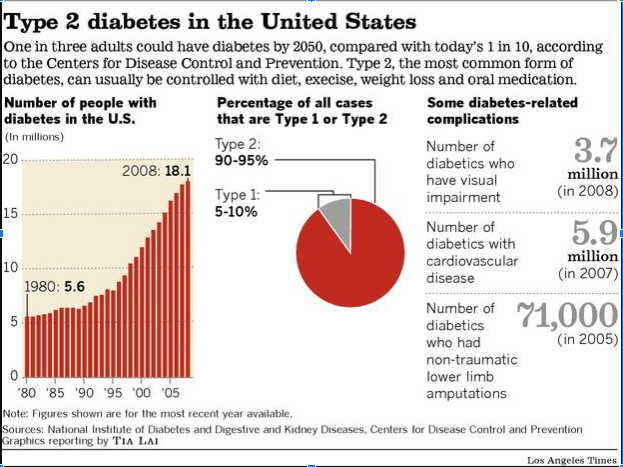

### In addition to the health costs associated with caring for diabetics, some states monitor health statistics regarding diabetes by practice, which can result in fines and legal action if it is determined that the practice population is not being properly managed.   

### The emotional and mental health burden is also notable, as managing diabetes can be stressful and may lead to anxiety and depression. Additionally, certain populations, including older adults, certain racial and ethnic groups, and those with lower socioeconomic status, are disproportionately affected by diabetes, highlighting a need for targeted public health interventions. The epidemic of diabetes underscores the importance of public health efforts focused on prevention, early detection, and effective management to mitigate its impact on individuals and society as a whole.

In [ ]:
# Make sure the requisite library is installed
!pip install ucimlrepo
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
# Import the pandas, and ucimlrepo libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

### Start Data Wrangling

In [2]:
# Fetch the diabetes dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets

In [3]:
# Load a dataframe with the target variable
target_df = pd.DataFrame(y)

In [4]:
# Check the data was loaded
target_df.head()

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0


In [5]:
# Load a dataframe with the features 
features_df = pd.DataFrame(X)

In [6]:
# Check the data
features_df.head(20)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
5,1,1,1,25,1,0,0,1,1,1,...,1,0,2,0,2,0,1,10,6,8
6,1,0,1,30,1,0,0,0,0,0,...,1,0,3,0,14,0,0,9,6,7
7,1,1,1,25,1,0,0,1,0,1,...,1,0,3,0,0,1,0,11,4,4
8,1,1,1,30,1,0,1,0,1,1,...,1,0,5,30,30,1,0,9,5,1
9,0,0,1,24,0,0,0,0,0,1,...,1,0,2,0,0,0,1,8,4,3


In [7]:
# Merge the 2 dataframes into 1
merged_df = target_df.merge(features_df, left_index=True, right_index=True)

In [8]:
# Check the merged data
merged_df.head(20)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
5,0,1,1,1,25,1,0,0,1,1,...,1,0,2,0,2,0,1,10,6,8
6,0,1,0,1,30,1,0,0,0,0,...,1,0,3,0,14,0,0,9,6,7
7,0,1,1,1,25,1,0,0,1,0,...,1,0,3,0,0,1,0,11,4,4
8,1,1,1,1,30,1,0,1,0,1,...,1,0,5,30,30,1,0,9,5,1
9,0,0,0,1,24,0,0,0,0,0,...,1,0,2,0,0,0,1,8,4,3


In [9]:
# Examine the metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# Examine the variable information 
print(cdc_diabetes_health_indicators.variables) 

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [10]:
# Access the 'features' part directly
features_data = cdc_diabetes_health_indicators.data

In [11]:
# Import the features (data) into a Pandas dataframe
features_df = pd.DataFrame(features_data.features)

In [12]:
# Examine the data
features_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [13]:
# Make sure we have the number of rows that are supposed to exist in the data set (253680)
merged_df.shape

(253680, 22)

#### To find the meaning of these features: https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/GENHLTH?archive=nahdap

In [14]:
# Do some preliminary statistices
merged_df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [15]:
# How much memory is the data set consuming
merged_df.size

5580960

In [16]:
# Check for NULL values
merged_df.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [17]:
# Put the column names in a dataframe for processing
df_cols = merged_df.columns

In [18]:
# Make sure we have an index
type(df_cols)

pandas.core.indexes.base.Index

In [19]:
# Check the unique values of each column and verify they look 
for column_name in merged_df.columns:
    print(f"Unique values: {column_name} for column:", merged_df[column_name].unique())

Unique values: Diabetes_binary for column: [0 1]
Unique values: HighBP for column: [1 0]
Unique values: HighChol for column: [1 0]
Unique values: CholCheck for column: [1 0]
Unique values: BMI for column: [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
Unique values: Smoker for column: [1 0]
Unique values: Stroke for column: [0 1]
Unique values: HeartDiseaseorAttack for column: [0 1]
Unique values: PhysActivity for column: [0 1]
Unique values: Fruits for column: [0 1]
Unique values: Veggies for column: [1 0]
Unique values: HvyAlcoholConsump for column: [0 1]
Unique values: AnyHealthcare for column: [1 0]
Unique values: NoDocbcCost for column: [0 1]
Unique values: GenHlth for column: [5 3 2 4 1]
Unique values: MentHlth for column: [18  0 30  3  5 15 10  6 20  2 25  1  4  7  8 21 14

In [20]:
# Save the files so we do not have to import it each time.
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_target.csv'
target_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_features.csv'
features_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_merged.csv'
merged_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')

### We can conclude that the data set matches the UC Irving Machine Learning Repository CDC Duiabetes data set
### The data is complete, there are no missing values and does not require any other wrangling.
### The data set is ready for use in the next phase Exploratory Data Analysis (EDA)

## End of Data Wrangling

## Begin Exploratory Data Analysis (EDA)

<html xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Excel.Sheet>
<meta name=Generator content="Microsoft Excel 15">
<link rel=File-List href="Data_Elements_files/filelist.xml">
<style id="Book1_489_Styles">
<!--table
	{mso-displayed-decimal-separator:"\.";
	mso-displayed-thousand-separator:"\,";}
.xl15489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl63489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:#1F2328;
	font-size:12.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:center;
	vertical-align:middle;
	background:white;
	mso-pattern:black none;
	white-space:normal;}
.xl64489
	{color:#1F2328;
	font-size:12.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:left;
	vertical-align:middle;
	border:.5pt solid windowtext;
	background:white;
	mso-pattern:black none;
	white-space:normal;
	padding-left:9px;
	mso-char-indent-count:1;}
.xl65489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:12.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	border:.5pt solid windowtext;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl66489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	border:.5pt solid windowtext;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl67489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:#0070C0;
	font-size:12.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:center;
	vertical-align:bottom;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
-->
</style>
<title>Data Elements</title>
</head>

<body>
<!--[if !excel]>&nbsp;&nbsp;<![endif]-->
<!--The following information was generated by Microsoft Excel's Publish as Web
Page wizard.-->
<!--If the same item is republished from Excel, all information between the DIV
tags will be replaced.-->
<!----------------------------->
<!--START OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD -->
<!----------------------------->

<div id="Book1_489" align=center x:publishsource="Excel">

<h1 style='color:black;font-family:Calibri;font-size:14.0pt;font-weight:800;
font-style:normal'>Data Elements</h1>

<table border=0 cellpadding=0 cellspacing=0 width=762 style='border-collapse:
 collapse;table-layout:fixed;width:572pt'>
 <col width=174 style='mso-width-source:userset;mso-width-alt:6363;width:131pt'>
 <col width=588 style='mso-width-source:userset;mso-width-alt:21504;width:441pt'>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl15489 width=174 style='height:17.25pt;width:131pt'></td>
  <td class=xl67489 width=588 style='width:441pt'>Data Elements</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl63489 width=174 style='height:17.25pt;width:131pt'>Feature</td>
  <td class=xl63489 width=588 style='width:441pt'>Description</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;width:131pt;
  box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Diabetes_binary</td>
  <td class=xl64489 width=588 style='border-left:none;width:441pt;box-sizing: border-box;
  border:var(--borderColor-default, var(--color-border-default))'>0 = no
  diabetes 1 = prediabetes/diabetes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>High
  blood pressure</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no high BP 1 = high BP.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>high
  cholesterol</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no high cholesterol 1 = high cholesterol.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Cholesterol
  Check</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>BMI</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Body
  Mass Index.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Smoker</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Have
  you smoked at least 100 cigarettes in your entire life? 0 = no 1 = yes.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Stroke</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>(Ever
  told) you had a stroke. 0 = no 1 = yes</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>HeartDiseaseorAttack</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>coronary
  heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes .</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>PhysActivity</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>physical
  activity in past 30 days - not including job 0 = no 1 = yes .</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Fruits</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Consume
  Fruit 1 or more times per day 0 = no 1 = yes .</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Veggies</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Consume
  Vegetables 1 or more times per day 0 = no 1 = yes.</td>
 </tr>
 <tr height=69 style='height:51.75pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=69 class=xl64489 width=174 style='height:51.75pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>HvyAlcoholConsump</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Heavy
  drinkers (adult men having more than 14 drinks per week and adult women
  having more than 7 drinks per week) 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>AnyHealthcare</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Have
  any kind of health care coverage, including health insurance, prepaid plans
  such as HMO, etc. 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>NoDocbcCost</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Was
  there a time in the past 12 months when you needed to see a doctor but could
  not because of cost? 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>GenHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Would
  you say that in general your health is: scale 1-5 1 = excellent 2 = very good
  3 = good 4 = fair 5 = poor.</td>
 </tr>
 <tr height=79 style='mso-height-source:userset;height:59.25pt;box-sizing: border-box;
  background-color:var(--bgColor-muted, var(--color-canvas-subtle));border-top:
  var(--borderColor-muted, var(--color-border-muted))'>
  <td height=79 class=xl64489 width=174 style='height:59.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>MentHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>Now thinking about your mental health, which includes stress,
  depression, and problems with emotions, for how many days during the past 30
  days was your mental health not good? scale 1-30 days</td>
 </tr>
 <tr height=69 style='height:51.75pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=69 class=xl64489 width=174 style='height:51.75pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>PhysHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Now
  thinking about your physical health , for how many days during the past 30
  days was your physical health not good? scale 1-30 days .</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>DiffWalk</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Do
  you have serious difficulty walking or climbing stairs? 0 = no 1 = yes.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Sex</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = female 1 = male</td>
 </tr>
 <tr height=115 style='height:86.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=115 class=xl64489 width=174 style='height:86.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Age</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>1
  - Age 18 to 24 / 2 - Age 25 to 29 / 3 - Age 30 to 34<br>
    4 - Age 35 to 39 / 5 - Age 40 to 44 / 6 - Age 45 to 49<br>
    7 - Age 50 to 54 / 8 - Age 55 to 59 / 9 - Age 60 to 64<br>
    10 - Age 65 to 69 / 11 - Age 70 to 74 / 12 - Age 75 to 70<br>
    13 - Age 80 or older</td>
 </tr>
 <tr height=115 style='height:86.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=115 class=xl64489 width=174 style='height:86.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Education</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Education
  level (EDUCA see codebook) scale 1-6 1 = Never attended school or only
  kindergarten , 2 = Grades 1 through 8 (Elementary) ,3 = Grades 9 throug 11
  (Some high school), 4 = Grade 12 or GED (High school graduate) , 5 = College
  1 year to 3 years (Some college or technical school) , 6 = College 4 years or
  more (College graduate).</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Income</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Income
  scale, scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or
  more.</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl65489 style='height:17.25pt;border-top:none'>mrna_booster</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>One or more Covid MRNA boosters</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl66489 style='height:17.25pt;border-top:none'>prior_covid</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>Prior COVID infection verified via test</td>
 </tr>
 <![if supportMisalignedColumns]>
 <tr height=0 style='display:none'>
  <td width=174 style='width:131pt'></td>
  <td width=588 style='width:441pt'></td>
 </tr>
 <![endif]>
</table>

</div>


<!----------------------------->
<!--END OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD-->
<!----------------------------->
</body>

</html>

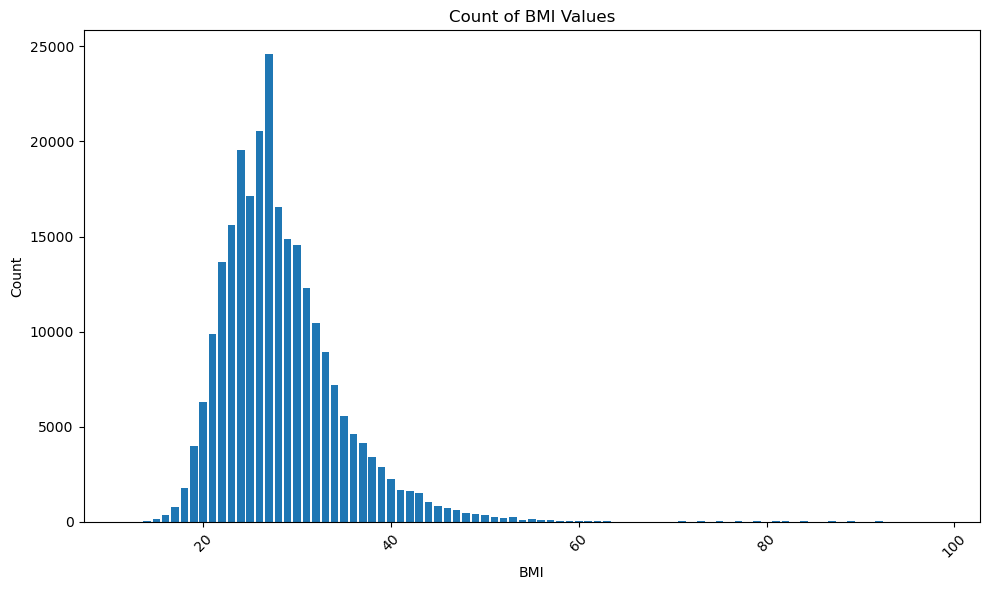

In [21]:
# Let's plot the BMI and see how it is distributed by value
# Count the occurrences of each unique value in the "BMI" column
bmi_counts = features_df['BMI'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(bmi_counts.index, bmi_counts.values)

# Always add labels and titles
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('Count of BMI Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

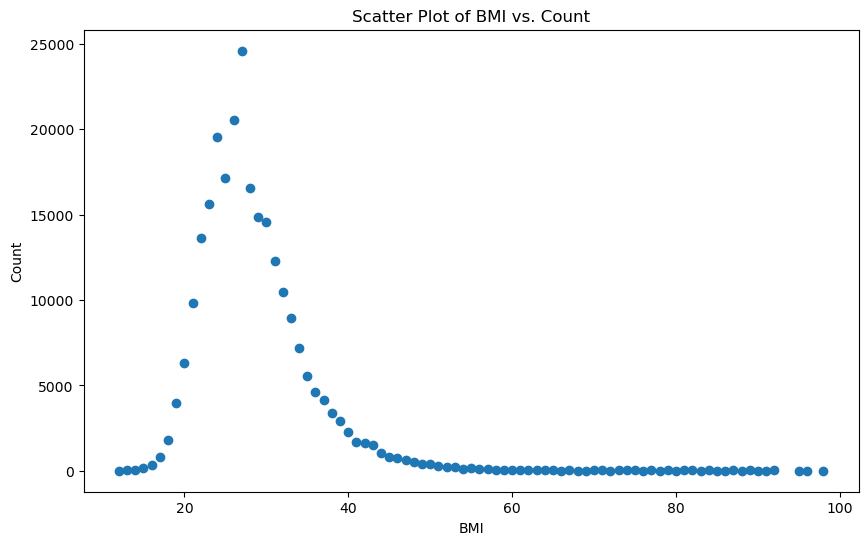

In [22]:
# Since the BMI is so right skewed, some values are barely visible on the bar chart, let's plot a scatter plot instead. 
# Set the figure size
plt.figure(figsize=(10, 6))  
bmi_counts = features_df['BMI'].value_counts().reset_index()
bmi_counts.columns = ['BMI', 'Count']

# Create the scatter plot
plt.scatter(bmi_counts['BMI'], bmi_counts['Count'])

# Set axes labels
plt.xlabel('BMI')
plt.ylabel('Count')

# Title the graph
plt.title('Scatter Plot of BMI vs. Count')

# Show the plot
plt.show()

GENHLTH: GENERAL HEALTH
Question: Prologue: Description: Would you say that in general your health is:

Value	Label	 
    1	Excellent
    2	Very good
    3	Good
    4	Fair
    5	Poor

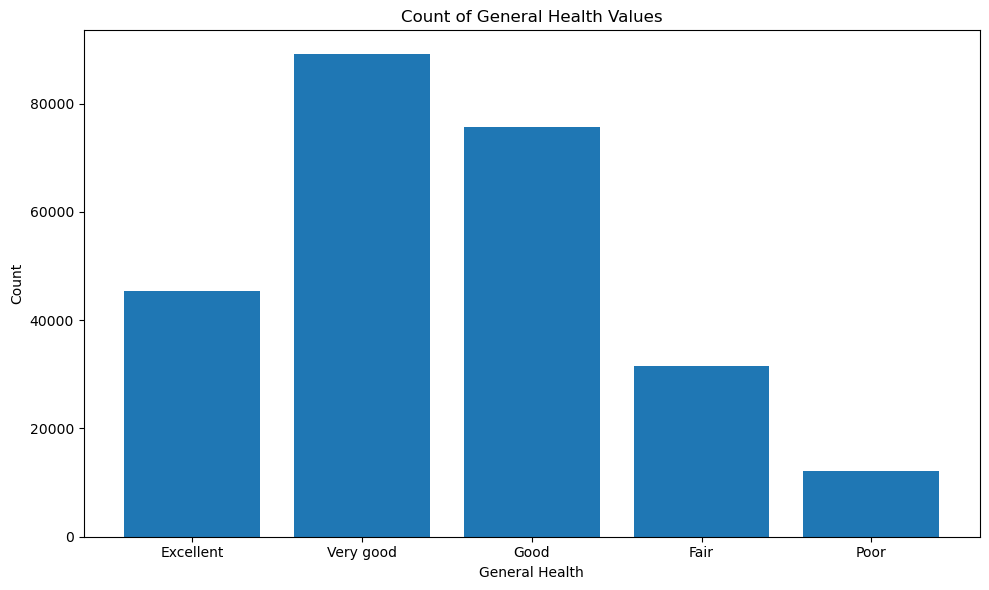

In [23]:
# Let's plot the General Health and see how it is distributed by value
# Create the bar chart

# Set the figure size
plt.figure(figsize=(10, 6))  

# Define the custom labels for the X-axis values
x_labels = {1: 'Excellent', 2: 'Very good', 3: 'Good', 4: 'Fair', 5: 'Poor'}

# Count the occurrences of each value in 'GenHlth'
gh_counts = features_df['GenHlth'].value_counts().sort_index()

# Create the bar chart
plt.bar(x_labels.values(), gh_counts)

# Always add labels and titles
plt.xlabel('General Health')
plt.ylabel('Count')
plt.title('Count of General Health Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

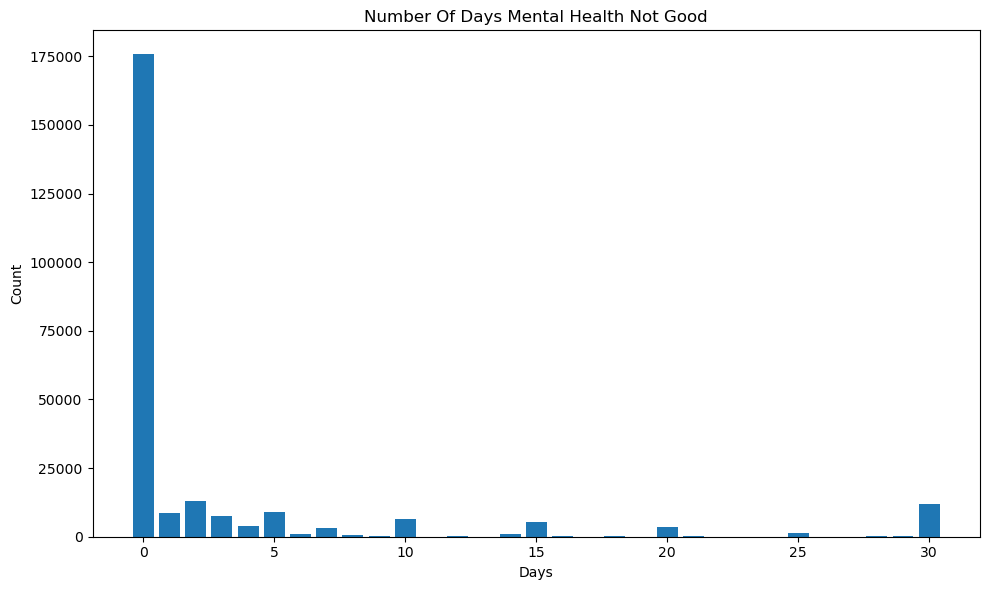

In [24]:
# Let's plot the Mental Health and see how it is distributed by value
# Count the occurrences of each unique value in the "MentHlth" column
mh_counts = features_df['MentHlth'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(mh_counts.index, mh_counts.values)

# Always add labels and titles
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Number Of Days Mental Health Not Good')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

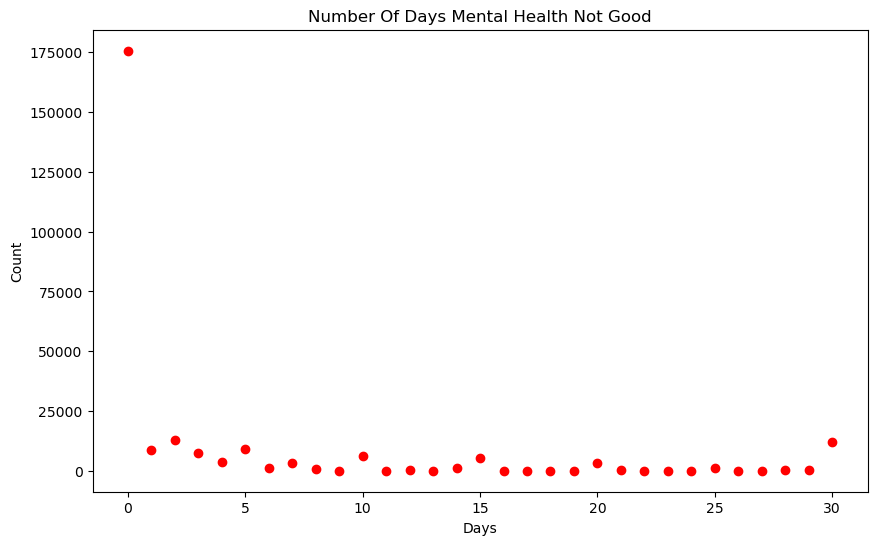

In [25]:
# Since the Mental Health is so right skewed, some values are barely visible on the bar chart, let's plot a scatter plot instead. 
# Set the figure size
plt.figure(figsize=(10, 6))  
mh_counts = features_df['MentHlth'].value_counts().reset_index()
mh_counts.columns = ['MentHlth', 'Count']

# Create the scatter plot
plt.scatter(mh_counts['MentHlth'], mh_counts['Count'], color='red')

# Set axes labels
plt.xlabel('Days')
plt.ylabel('Count')

# Title the graph
plt.title('Number Of Days Mental Health Not Good')

# Show the plot
plt.show()

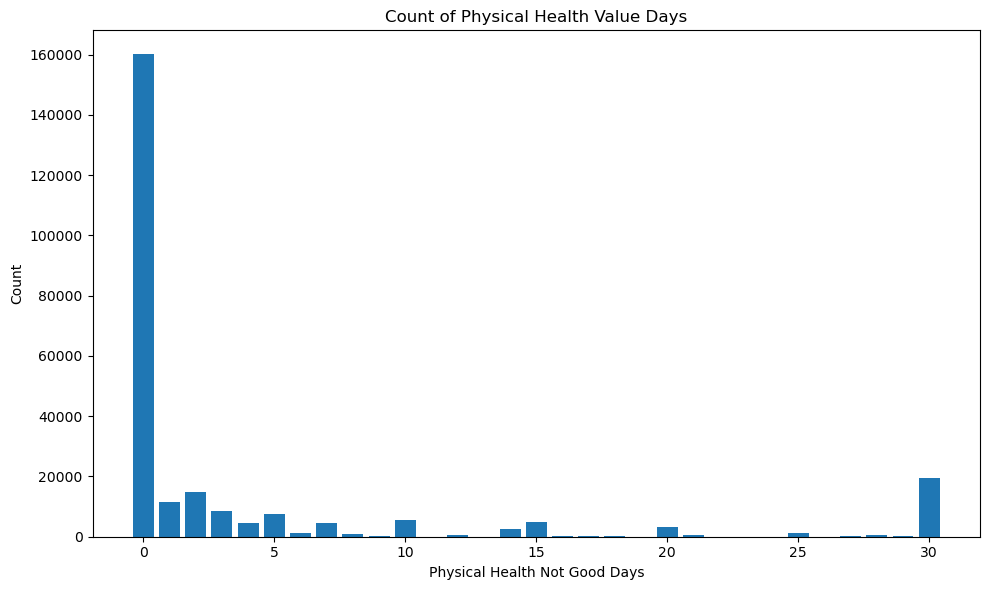

In [26]:
# Let's plot the Physical Health and see how it is distributed by value
# Count the occurrences of each unique value in the "PhysHlth" column
ph_counts = features_df['PhysHlth'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(ph_counts.index, ph_counts.values)

# Always add labels and titles
plt.xlabel('Physical Health Not Good Days')
plt.ylabel('Count')
plt.title('Count of Physical Health Value Days')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

Sex Column
Value    Label
  1      Male
  0      Female

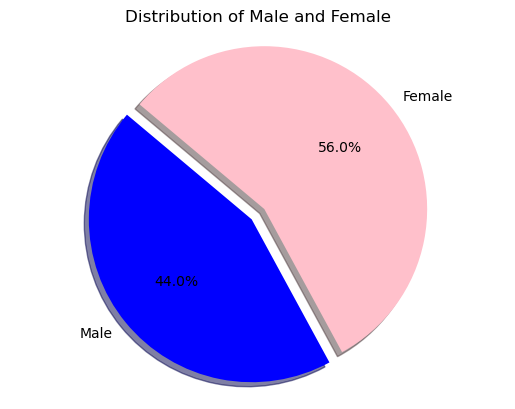

In [27]:
male_count = (features_df['Sex'] == 1).sum()
female_count = (features_df['Sex'] == 0).sum()

# Create a pie chart
labels = ['Male', 'Female']
sizes = [male_count, female_count]
colors = ['blue', 'pink'] 
explode = (0.1, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 

# Add a title
plt.title('Distribution of Male and Female')

# Show the pie chart
plt.show()

The age data is binned as follows: 
1 Age 18 to 24
2 Age 25 to 29
3 Age 30 to 34
4 Age 35 to 39
5 Age 40 to 44
6 Age 45 to 49
7 Age 50 to 54
8 Age 55 to 59
9 Age 60 to 64
10 Age 65 to 69
11 Age 70 to 74
12 Age 75 to 79
13 Age 80 or older

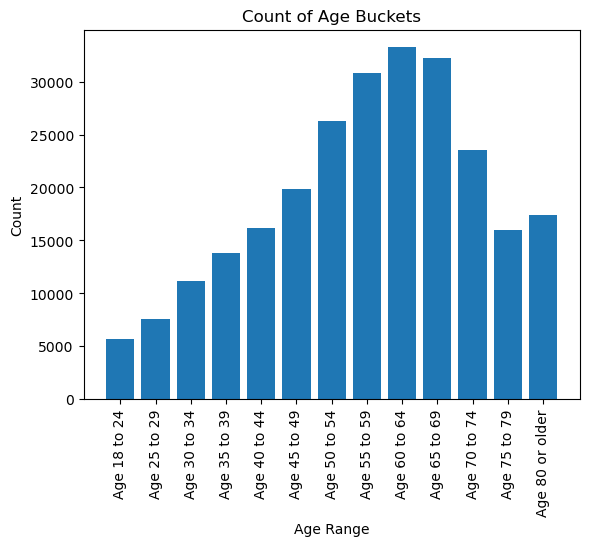

In [28]:
# Define the age buckets
custom_labels = {
    1: 'Age 18 to 24',
    2: 'Age 25 to 29',
    3: 'Age 30 to 34',
    4: 'Age 35 to 39',
    5: 'Age 40 to 44',
    6: 'Age 45 to 49',
    7: 'Age 50 to 54',
    8: 'Age 55 to 59',
    9: 'Age 60 to 64',
    10: 'Age 65 to 69',
    11: 'Age 70 to 74',
    12: 'Age 75 to 79',
    13: 'Age 80 or older'
}

# Count the occurrences of each age value
counts = features_df['Age'].value_counts().sort_index()

# Create the bar chart
plt.bar(custom_labels.values(), counts)

# Set labels for X and Y axes
plt.xlabel('Age Range')
plt.ylabel('Count')

# Set custom X-axis tick labels and rotate them 90 degrees
plt.xticks(rotation=90)

# Set a title
plt.title('Count of Age Buckets')

# Show graph
plt.show()

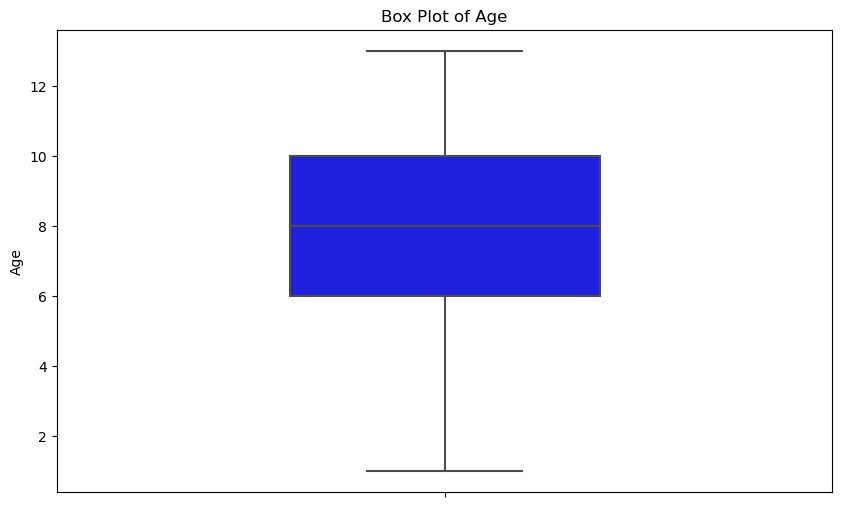

In [29]:
# Create a boxplot for the 'Age' column
plt.figure(figsize=(10, 6))  
sns.boxplot(y='Age', data=merged_df, color='blue', width=0.4)

# Add labels and title
plt.ylabel('Age')
plt.title('Box Plot of Age')

# Show the plot
plt.show()

In [ ]:
## Do NOT run at this time
# Create a swarm plot for the 'Age' column
plt.figure(figsize=(8, 6))  
sns.swarmplot(y='Age', data=merged_df, color='green')

# Add labels and title
plt.ylabel('Age')
plt.title('Swarm Plot of Age')

# Show the plot
plt.show()

What is the highest grade or year of school you completed? = Education

1 Never attended school or only kindergarten
2 Grades 1 through 8 (Elementary)
3 Grades 9 through 11 (Some high school)
4 Grade 12 or GED (High school graduate)
5 College 1 year to 3 years (Some college or technical school)
6 College 4 years or more (College graduate)
9 Refused (All these records were deleted from the dataset)

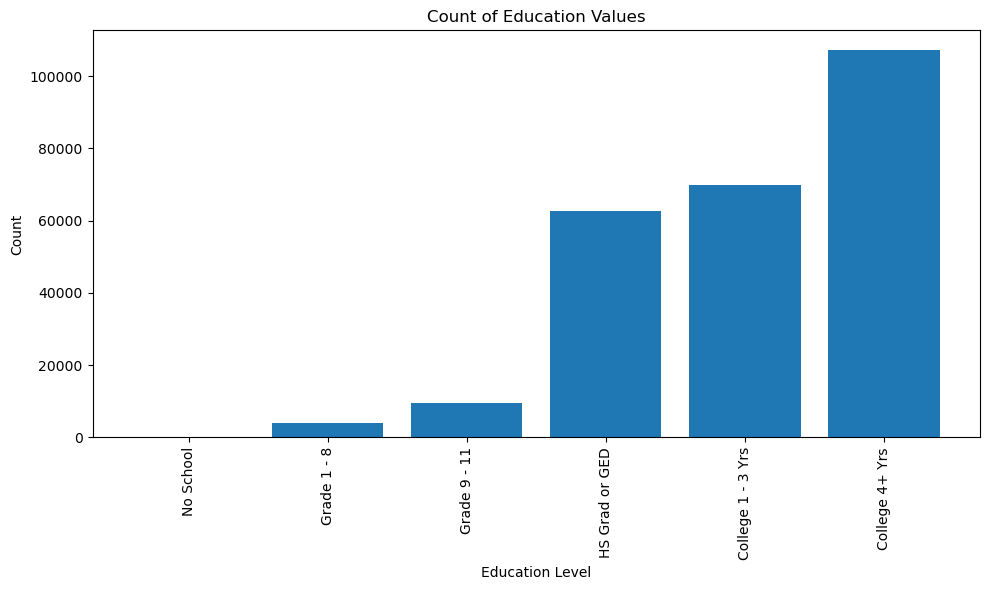

In [30]:
# Let's plot the Education count and see how it is distributed in this data set

custom_labels = {
    1: 'No School',
    2: 'Grade 1 - 8',
    3: 'Grade 9 - 11',
    4: 'HS Grad or GED',
    5: 'College 1 - 3 Yrs',
    6: 'College 4+ Yrs'
}

# Count the occurrences of each unique value in the "Education" column
educ_counts = features_df['Education'].value_counts().sort_index()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
# plt.bar(educ_counts.index, educ_counts.values)
plt.bar(custom_labels.values(), educ_counts)

# Always add labels and titles
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Count of Education Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

Income scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

1 Less than $10,000
2 Less than $15,000 ($10,000 to less than $15,000)
3 Less than $20,000 ($15,000 to less than $20,000)
4 Less than $25,000 ($20,000 to less than $25,000)
5 Less than $35,000 ($25,000 to less than $35,000)
6 Less than $50,000 ($35,000 to less than $50,000)
7 Less than $75,000 ($50,000 to less than $75,000)
8 $75,000 or more

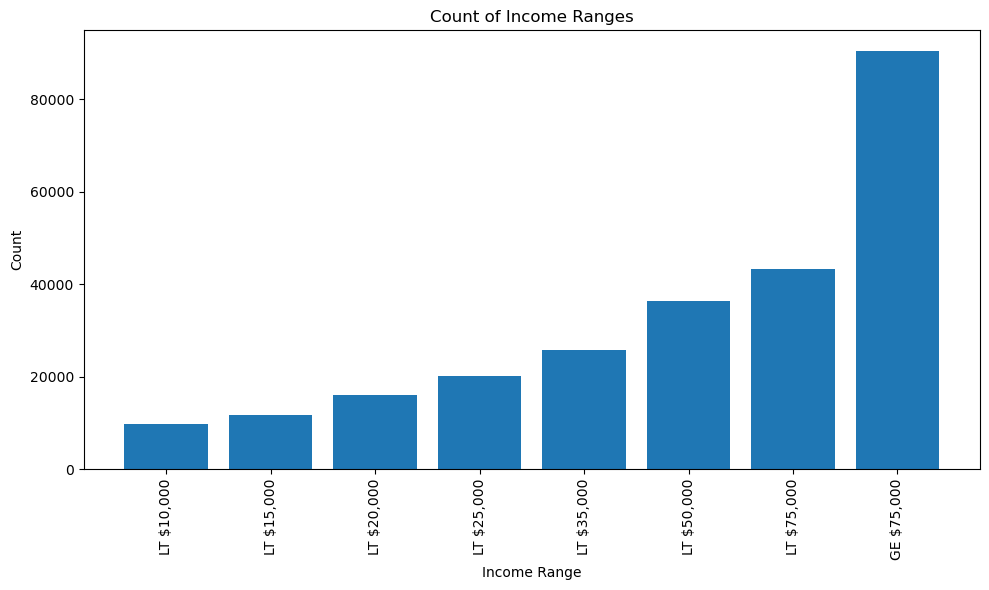

In [33]:
# Let's plot the Income count and see how it is distributed in this data set

custom_labels = {
    1: 'LT $10,000',
    2: 'LT $15,000',
    3: 'LT $20,000',
    4: 'LT $25,000',
    5: 'LT $35,000',
    6: 'LT $50,000',
    7: 'LT $75,000',
    8: 'GE $75,000'
}

# Count the occurrences of each unique value in the "Income" column
inc_counts = features_df['Income'].value_counts().sort_index()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
#plt.bar(bmi_counts.index, inc_counts.values)
plt.bar(custom_labels.values(), inc_counts.values)

# Always add labels and titles
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Count of Income Ranges')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

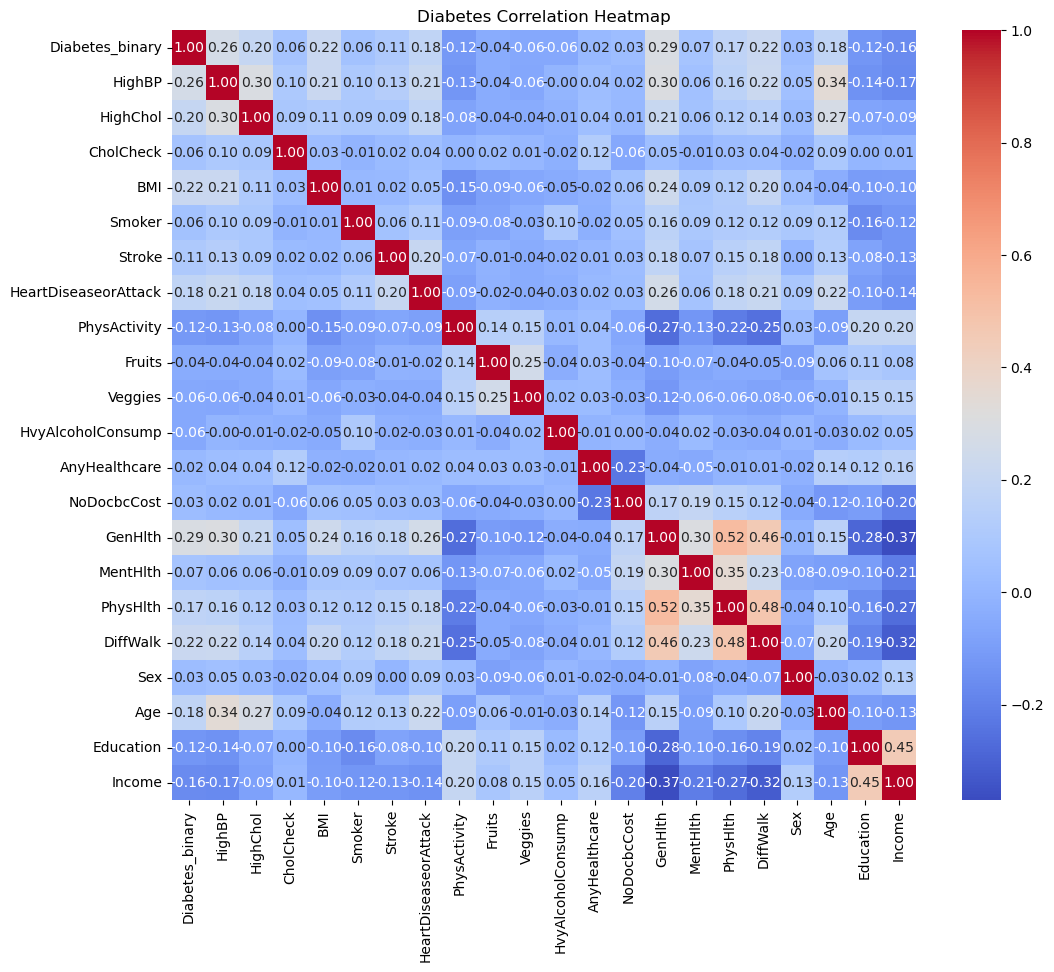

In [34]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(12, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title
plt.title("Diabetes Correlation Heatmap")

# Show the plot
plt.show()

In [35]:
# Calculate the Pearson correlation coefficients for 'Diabetes_binary' with other features
correlation_with_target = merged_df.corr(method='pearson')['Diabetes_binary'].drop('Diabetes_binary')

In [36]:
print("The Pearson correlation coefficients for the target variable: Diabetes_binary\n", correlation_with_target)

The Pearson correlation coefficients for the target variable: Diabetes_binary
 HighBP                  0.263129
HighChol                0.200276
CholCheck               0.064761
BMI                     0.216843
Smoker                  0.060789
Stroke                  0.105816
HeartDiseaseorAttack    0.177282
PhysActivity           -0.118133
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
AnyHealthcare           0.016255
NoDocbcCost             0.031433
GenHlth                 0.293569
MentHlth                0.069315
PhysHlth                0.171337
DiffWalk                0.218344
Sex                     0.031430
Age                     0.177442
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64


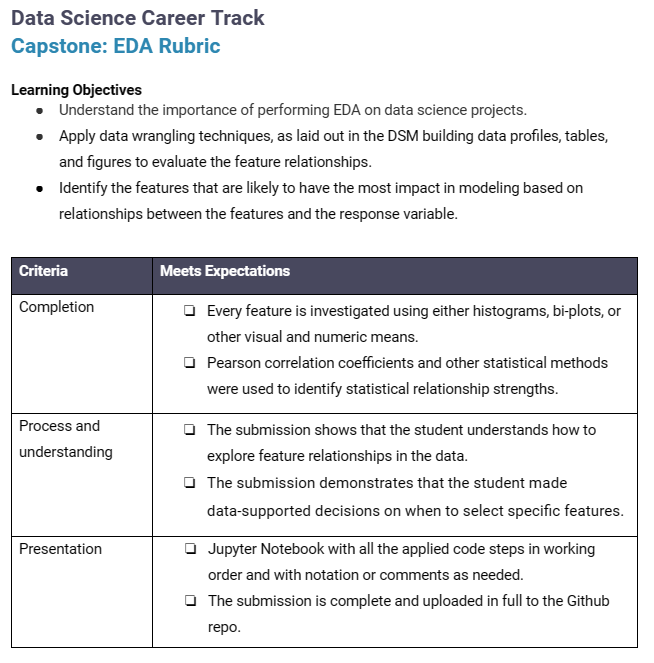

In [ ]:
## End Exploratory Data Analysis (EDA)

In [ ]:
 ## Begin Pre-processing & Training Data Development

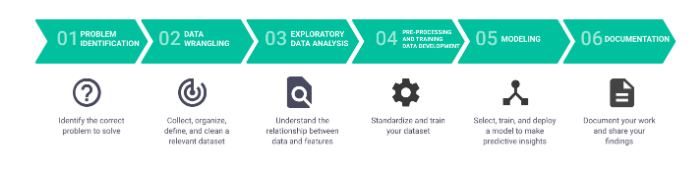

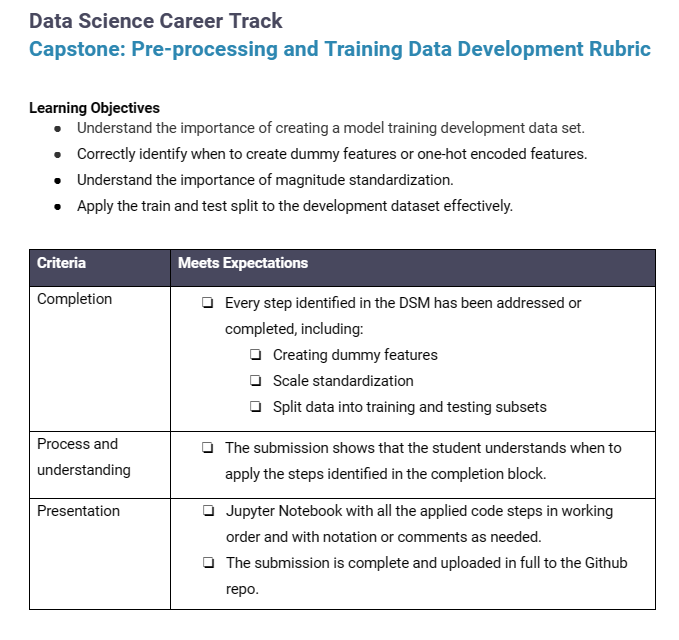

In [37]:
import numpy as np

# Create random data for mrna_booster and prior_covid
np.random.seed(47)  # Set a seed for reproducibility

# Generate random values for mrna_booster (72% TRUE, 28% FALSE)
merged_df['mrna_booster'] = np.random.choice([1, 0], size=len(merged_df), p=[0.72, 0.28])

# Generate random values for prior_covid (57% TRUE, 43% FALSE)
merged_df['prior_covid'] = np.random.choice([1, 0], size=len(merged_df), p=[0.57, 0.43])

# Verify the result
print(merged_df[['Diabetes_binary', 'prior_covid', 'mrna_booster']].head())

   Diabetes_binary  prior_covid  mrna_booster
0                0            1             1
1                0            1             0
2                0            1             0
3                0            1             1
4                0            1             1


In [40]:
# Run LogisticRegression model with NO scaling as logistic regression is not as sensitive to feature scaling 
#     as some other algorithms
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Define the target variable and features
X = merged_df.drop("Diabetes_binary", axis=1)  # Features (all columns except Diabetes_binary)
y = merged_df["Diabetes_binary"]  # Diabetes_binary is the target variable

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Instantiate the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=47)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Model: Logistic Regression Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Logistic Regression Model
Accuracy: 0.8635485651214128
F1 Score: 0.24446142093200915
Precision: 0.5288007554296507
Recall: 0.1589779985805536
Confusion Matrix:
[[42693   998]
 [ 5925  1120]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736





In [41]:
# Save the unscaled data
X_train_unscaled = X_train
X_test_unscaled  = X_test
y_train_unscaled = y_train
y_test_unscaled  = y_test

In [42]:
# Now use the standard scaler to scale the non-binary data
# Import for standardization
from sklearn.preprocessing import StandardScaler  

# Instantiate 
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_train[['GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])

# Transform the training and testing data
X_train[['GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']] = scaler.transform(X_train[['GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])
X_test[['GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']] = scaler.transform(X_test[['GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])

In [43]:
# Instantiate the Logistic Regression model 
model = LogisticRegression(max_iter=1000, random_state=47)

# Fit the model to the scaled training data
model.fit(X_train, y_train)

# Make predictions on the scaled test data
y_pred = model.predict(X_test)

In [44]:
# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Model: Logistic Regression Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Logistic Regression Model
Accuracy: 0.8635485651214128
F1 Score: 0.24446142093200915
Precision: 0.5288007554296507
Recall: 0.1589779985805536
Confusion Matrix:
[[42693   998]
 [ 5925  1120]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736





In [45]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from catboost import CatBoostClassifier, Pool

In [46]:
# Define the list of models to process for comparison
models = [
    ('Random Forest', RandomForestClassifier(random_state=47)),
    ('SVM', SVC(random_state=47)),
    ('XGBoost', xgb.XGBClassifier(random_state=47)),
    ('LightGBM', lgb.LGBMClassifier(random_state=47)),
    ('CatBoost', cat.CatBoostClassifier(random_state=47, verbose=0)) 
]


# Create the list of pipelines for each model to be used the next step
pipelines = []
for model_name, model in models:
    pipelines.append((
        model_name,
        Pipeline([
            ('Scaler', StandardScaler()),  
            ('Model', model)  
        ])
    ))

In [47]:
# Calculate the elapsed run time of each model
import time
start = time.time()

for model_name, model_pipeline in pipelines:
    # Fit the model using the pipeline
    model_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_pipeline.predict(X_test)
    
    # Calculate performance measures
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report_str}")
    print("\n")
    print(f"Elapsed Run Time: ", time.time() - start)

Model: Random Forest
Accuracy: 0.8619126458530432
F1 Score: 0.23681917211328973
Precision: 0.5091334894613583
Recall: 0.15429382540809083
Confusion Matrix:
[[42643  1048]
 [ 5958  1087]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736



Model: SVM
Accuracy: 0.8652436140018922
F1 Score: 0.14097248398039955
Precision: 0.6137855579868708
Recall: 0.07963094393186657
Confusion Matrix:
[[43338   353]
 [ 6484   561]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58

 ## End Pre-processing & Training Data Development